<b><div style="text-align:right">Алексей Бебчик&nbsp;&nbsp;</div><b>
### Курс 6. Желтое такси. Неделя 2 (задание, оцениваемое сокурсниками)


В этом <a href="https://www.coursera.org/learn/data-analysis-project/peer/EVQL9/rabota-s-ghieodannymi">задании</a> вам предстоит научиться работать с географическими данными. В Питоне есть огромное количество библиотек, позволяющих эти данные обрабатывать и визуализировать; выберите ту, которая вам больше понравится. Вам может помочь руководство kaggle по работе с картами: <a href="http://blog.kaggle.com/2016/11/30/seventeen-ways-to-map-data-in-kaggle-kernels/">Семнадцать способов рисовать данные на картах"</a>. Смотрите также:  

•модуль <a href="http://matplotlib.org/basemap/">basemap</a> (<a href="https://www.machinalis.com/blog/embedding-interactive-maps-into-an-ipython-nb/">пример</a>, <a href="https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/04.13-Geographic-Data-With-Basemap.ipynb">ещё пример</a>)  
•плагин <a href="https://github.com/pbugnion/gmaps">gmaps</a>  
•виджет <a href="https://github.com/ellisonbg/ipyleaflet">ipyleaflet</a> (<a href="https://github.com/ellisonbg/ipyleaflet/blob/master/examples/MapContainer.ipynb">крайне минималистичный пример)</a>  
•модуль <a href="https://github.com/python-visualization/folium">folium</a>  

Поскольку мы агрегировали данные по равномерной сетке, можно ожидать, что существенное количество ячеек окажется в районах города, где вызов такси невозможен (реки, заливы, острова, парки). Теоретически ряды, соответствующие таким ячейка, должны состоять из одних нулей, но на практике это может быть не так: устройства, определяющие координаты автомобилей в момент начала поездки, несовершенны и могут ошибаться, показывая, например, что такси находится в середине реки. Чтобы правильно отобрать ячейки, вам понадобится визуализировать их границы на карте и отфильтровать те, из которых поездки на такси невозможны.   


Чтобы сдать задание, выполните следующую последовательность действий.  

1.Загрузите агрегированные данные о поездках в мае 2016. Просуммируйте общее количество поездок такси из каждой географической зоны и посчитайте количество ячеек, из которых в мае не было совершено ни одной поездки.  

2.Нарисуйте статическую карту Нью-Йорка. Поставьте на карте точку там, где находится Эмпайр-Стейт-Билдинг.  

3.Поверх статической карты Нью-Йорка визуализируйте данные о поездках из каждой ячейки так, чтобы цветовая шкала, в которую вы окрашиваете каждую ячейку, показывала суммарное количество поездок такси из неё.  

4.Вставьте интерактивную карту Нью-Йорка — такую, которую можно прокручивать и увеличивать. Поставьте метку там, где находится статуя свободы.  

5.Нарисуйте на интерактивной карте Нью-Йорка ячейки так, чтобы их цвет показывал среднее за месяц количество поездок такси в час из этой зоны.  

6.Чтобы не выбирать из всех 2500 ячеек вручную, отфильтруйте ячейки, из которых в мае совершается в среднем меньше 5 поездок в час. Посчитайте количество оставшихся. Проверьте на карте, что среди этих ячеек нет таких, из которых поездки на самом деле невозможны.  

7.Сохраните ноутбук в формате html, запакуйте ipynb и html в один архив и загрузите его в форму (html облегчит задачу проверки вашим рецензентам — в ipynb динамические карты часто не сохраняются, а для выполнения кода рецензентам придётся устанавливать все библиотеки).



__Нам понадобятся библиотеки для рабы с картами и форматами гео-данных:__  
pip install folium  
pip install geojson     
__ выполняем из cmd.exe, запущенного с правами администратора__  

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic_2d
import itertools
import geojson
from   mpl_toolkits.basemap import Basemap
import folium

__1.Загрузите агрегированные данные о поездках в мае 2016. Просуммируйте общее количество поездок такси из каждой географической зоны и посчитайте количество ячеек, из которых в мае не было совершено ни одной поездки__

In [2]:
#Загружаем данные из предыдущего задания (файл приложен в архиве)
df5hr = pd.read_csv('yellow_tripdata_2016-05_HDRall.csv', sep=',')
df5hr.head(3)

,dayhour,region,cnt
0,2016-05-01 00:00:00,1,0
1,2016-05-01 00:00:00,2,0
2,2016-05-01 00:00:00,3,0


In [9]:
#Загружаем районы
dfreg = pd.read_csv('regions.csv', sep=';') 
dfreg.head(3)

,region,west,east,south,north
0,1,-74.25559,-74.244478,40.496120,40.504508
1,2,-74.25559,-74.244478,40.504508,40.512896
2,3,-74.25559,-74.244478,40.512896,40.521285


In [10]:
#Группируем данные по районам без учета разбивки по часам
df5r = df5hr.groupby(['region'], as_index=False).cnt.sum()
df5r.head(3)

,region,cnt
0,1,0
1,2,0
2,3,0


In [91]:
print 'Ячейки с нулевым количеством поездок:', df5r[df5r.cnt==0].region.size

Ячейки с нулевым количеством поездок: 1283


In [12]:
#Добавим столбецы с координатами районов
df5r[['west','east','south','north']] = pd.merge(df5r, dfreg, how='inner', on = ['region'])[['west','east','south','north']]
df5r['lon'] = (df5r.west  + df5r.east)  / 2.0 #центр района
df5r['lat'] = (df5r.south + df5r.north) / 2.0 #центр района
df5r.head(3)

,region,cnt,west,east,south,north,lon,lat
0,1,0,-74.25559,-74.244478,40.496120,40.504508,-74.250034,40.500314
1,2,0,-74.25559,-74.244478,40.504508,40.512896,-74.250034,40.508702
2,3,0,-74.25559,-74.244478,40.512896,40.521285,-74.250034,40.517090


__2.Нарисуйте статическую карту Нью-Йорка. Поставьте на карте точку там, где находится Эмпайр-Стейт-Билдинг.__

In [13]:
x0, x1, y0, y1 = -74.25559, -73.700018, 40.49612, 40.91553  #квадрат Нью-Йорка
cx, cy = (-74.25559+-73.700018)/2, (40.49612+40.91553)/2    #центр квадрата

In [14]:
emp_x, emp_y = -73.985428, 40.748817 #координаты Empire State Building (взяты из интернета)

In [15]:
rlons = sorted(set(dfreg.west.unique())  | set(dfreg.east.unique()) ) #сетка районов по х
rlats = sorted(set(dfreg.south.unique()) | set(dfreg.north.unique())) #сетка районов по y
rdata = np.array(df5r.sort_values('region').cnt).reshape([50,50])     #данные в виде двумерного массива (строки-y, стобцы-x)

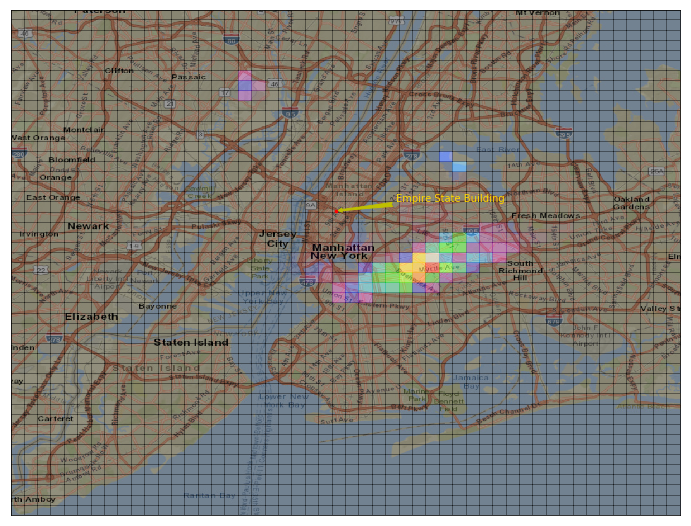

In [111]:
plt.figure(figsize=(12, 12))
m = Basemap(llcrnrlon=x0, llcrnrlat=y0, urcrnrlon=x1, urcrnrlat=y1, lat_0=cx, lon_0=cy, 
            resolution = 'h', 
            projection = 'moll',
            epsg       = 4269)
   
m.arcgisimage(service='World_Street_Map', xpixels=1200) #, dpi=96) #, ypixels=None)

x,y = m(rlons,rlats)

#Устанавливаем палитру
my_cmap = plt.get_cmap('spectral') #rainbow, 'RdBu_r'
my_cmap.set_under('white')

#Рисуем агрегированные данные на карте
cs = m.pcolormesh(x,y,rdata, cmap=my_cmap, alpha=0.4)

#Рисуем точку Empire State Building
ex,ey = m(emp_x,emp_y)
m.scatter(ex, ey, 7, marker='o', color='r')

#Рисуем точку стрелку и подпись Empire State Building
plt.annotate('Empire State Building', 
             xy=(ex,ey), 
             xytext=(60,10), #xytext=m(ex-5,ey+5),
             xycoords='data',
             textcoords='offset points', #textcoords='data',
             color='gold', 
             arrowprops=dict(arrowstyle='fancy', color='y'))

plt.show()

__4.Вставьте интерактивную карту Нью-Йорка — такую, которую можно прокручивать и увеличивать. Поставьте метку там, где находится статуя свободы.__

In [17]:
# Координаты Статуи свободы (https://www.gps-latitude-longitude.com/gps-coordinates-of-statue-of-liberty)
liberty_lon = -74.044500  
liberty_lat =  40.689249 

In [79]:
# Среднее число поездок в час
df5mean = df5hr.groupby('region', as_index=False)['cnt'].mean()

In [60]:
# Сформируем данные для показа на карте в формете GeoJSON
regs_with_data = df5hr[df5hr.cnt>0].region.unique() #регионы с поездками (для оптимищации)
reg_features  = []
regD_features = []
regD5_features = []

for i, row in dfreg.iterrows():
    
    cnt = 0

    if row.region in (regs_with_data): #работает быстро, но тоже как-то не очень красиво (м.б. лучше сделат словарь)
        cnt = df5hr[df5hr.region == row.region].cnt.get_values()[0] 

    #порядок имеет значение, нельзя просто сотсавлять любые пары
    reg_coord   = [(row.west, row.south), (row.west, row.north), (row.east, row.north), (row.east, row.south)]
    reg_poligon = geojson.Polygon([reg_coord])
    reg_feature = geojson.Feature(geometry=reg_poligon, id=row.region,
                                  properties={"name":row.region, "description":'reg'+str(row.region)})

    reg_features.append(reg_feature)
    if cnt >  0: regD_features.append(reg_feature) #есть данные  (есть поездки)
    if cnt >= 5: regD5_features.append(reg_feature) #есть данные (5 и более поездок)

reg_feature_col   = geojson.FeatureCollection(reg_features)
regD_feature_col  = geojson.FeatureCollection(regD_features)
regD5_feature_col = geojson.FeatureCollection(regD5_features)

__ 5.Нарисуйте на интерактивной карте Нью-Йорка ячейки так, чтобы их цвет показывал среднее за месяц количество поездок такси в час из этой зоны. __

In [83]:
m = folium.Map(location=[cy, cx], zoom_start=10, tiles='Stamen Toner')

folium.Marker([liberty_lat, liberty_lon], popup='<i>Statue Of Liberty ('+str(liberty_lat)+
              ','+ str(liberty_lon) + ')</i>').add_to(m)

m.choropleth(
    geo_data     = reg_feature_col,
    name         = 'choropleth',
    data         = df5mean,
    columns      = ['region', 'cnt'],
    key_on       = 'feature.id',
    fill_color   = 'YlOrRd', 
    fill_opacity = 0.5,
    line_opacity = 0.2,
    legend_name  = 'Trips at hour (all trips)'
)

m.add_child(folium.LatLngPopup()) #при клики показываются координаты

m

__ 6.Чтобы не выбирать из всех 2500 ячеек вручную, отфильтруйте ячейки, из которых в мае совершается в среднем меньше 5 поездок в час. Посчитайте количество оставшихся. Проверьте на карте, что среди этих ячеек нет таких, из которых поездки на самом деле невозможны. __

In [84]:
m = folium.Map(location=[cy, cx], zoom_start=10, tiles='Stamen Toner')

folium.Marker([liberty_lat, liberty_lon], popup='<i>Statue Of Liberty ('+str(liberty_lat)+
              ','+ str(liberty_lon) + ')</i>').add_to(m)

m.choropleth(
    geo_data     = regD5_feature_col,
    name         = 'choropleth',
    data         = df5mean[df5mean.cnt>=5],
    columns      = ['region', 'cnt'],
    key_on       = 'feature.id',
    fill_color   = 'YlOrRd',
    fill_opacity = 0.5,
    line_opacity = 0.2,
    legend_name  = 'Trips at hour (5 and more trips)'
)

m.add_child(folium.LatLngPopup()) #при клики показываются координаты

m

__   
Число районов, из которых совершено 5 и более поездок: __

In [70]:
print df5mean[df5mean['cnt'] >= 5]['region'].shape[0]

102


In [73]:
# Для интерактивного режима может быть полезен следующий код с выбором порогового числа поездок

# n_trips = 5 #задавая n_trips {0,1,5} выбираем {все регионы, регионы хотя бы одной поездкой, регионы числом поездок 5 и более}

# if n_trips == 0: geo = reg_feature_col    
# if n_trips == 1: geo = regD_feature_col
# if n_trips == 5: geo = regD5_feature_col
    
# m = folium.Map(location=[cy, cx], zoom_start=10, tiles='Stamen Toner')

# folium.Marker([liberty_lat, liberty_lon], popup='<i>Statue Of Liberty ('+str(liberty_lat)+
#               ','+ str(liberty_lon) + ')</i>').add_to(m)

# m.choropleth(
#     geo_data     =  geo,
#     name         = 'choropleth',
#     data         = df5mean[df5mean.cnt>=n_trips],
#     columns      = ['region', 'cnt'],
#     key_on       = 'feature.id',
#     fill_color   = 'YlOrRd',
#     fill_opacity = 0.5,
#     line_opacity = 0.2,
#     legend_name  = 'Trips at hour (' + str(n_trips) + ' and more trips)'
# )

# m.add_child(folium.LatLngPopup()) #при клики показываются координаты

# m

__Используемые ссылки:__   

Basemap:     
https://www.mapbox.com/maps/light-dark/  
http://ramiro.org/notebook/new-york-roads-railways/  
https://matplotlib.org/basemap/users/examples.html  
https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/04.13-Geographic-Data-With-Basemap.ipynb  

Folium:   
https://github.com/d3-node/choropleth-us-states/blob/master/us-states.json https://stackoverflow.com/questions/11707281/usa-borders-in-json-format https://blog.dominodatalab.com/creating-interactive-crime-maps-with-folium/ https://app.dominodatalab.com/u/r00sj3/crimemaps/view/examples.ipynb https://blog.dominodatalab.com/creating-interactive-crime-maps-with-folium/ https://data.sfgov.org/Geographic-Locations-and-Boundaries/Current-Supervisor-Districts/8nkz-x4ny
https://blog.dominodatalab.com/author/roos/ https://data.sfgov.org/Public-Safety/Police-Department-Incidents-Current-Year-2018-/956q-2t7k 
http://ogre.adc4gis.com/   
google search: us-states.json download https://github.com/python-visualization/folium/blob/master/examples/data/us-states.json?short_path=3036216 https://github.com/python-visualization/folium/issues/425

http://www.datavis.ca/sasmac/brewerpal.html (Цвеотовая палитра: 'BuGn', 'BuPu', 'GnBu', 'OrRd', 'PuBu', 'PuBuGn', 'PuRd', 'RdPu', 'YlGn', 'YlGnBu', 'YlOrBr', and 'YlOrRd')